# imports and getting df and its schema

In [3]:
import pandas as pd
import numpy as np
from typing import List, Dict, Tuple
import itertools
import string
import re
import random

In [4]:
import torch

mounting my drive to get the data i uploaded the data in my drive to make it easy for me not uploading it every runtime


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
df = pd.read_csv('/content/drive/MyDrive/task2.csv')

In [7]:
df.head()

,cell_no,hour,month,day,year,Bandwidth,counter_0,counter_1,counter_2,counter_3,counter_4,counter_5
0,0,0,6,12,2019,10,470620,367862,214295,3592,123759,"[0.0, 513392.0, 792138.0, 47284.0, 22429.0, 15..."
1,0,1,6,12,2019,10,129657,80729,37125,2698,72283,"[0.0, 1886861.0, 1579023.0, 67836.0, 23810.0, ..."
2,0,2,6,12,2019,10,28839,18523,7949,1,21925,"[0.0, 2024560.0, 1288489.0, 213675.0, 33865.0,..."
3,0,3,6,12,2019,10,17751,17845,5292,0,10683,"[0.0, 2089627.0, 1239282.0, 231054.0, 18927.0,..."
4,0,4,6,12,2019,10,42836,35334,12739,0,24262,"[0.0, 2064013.0, 1355993.0, 132165.0, 18483.0,..."


get the schema of the data to make the model better understand my data and improve accuracy with LangChain

*   It provides an easy way to understand the structure of the DataFrame, including the column names and their corresponding data types


In [10]:
def get_dataframe_schema(df: pd.DataFrame) -> str:
    schema = []
    for col_name, dtype in df.dtypes.items():
        schema.append(f"{col_name} ({dtype})")
    return ", ".join(schema)

In [11]:
schema = get_dataframe_schema(df)

In [12]:
schema

'cell_no (int64), hour (int64), month (int64), day (int64), year (int64), Bandwidth (int64), counter_0 (int64), counter_1 (int64), counter_2 (int64), counter_3 (int64), counter_4 (int64), counter_5 (object)'

# uploading the training dataset

i found a dataset in huggingface that will help us to retrain our model to our spacific task ,

it is opensource ,

link: https://huggingface.co/datasets/Rahima411/text-to-pandas

In [8]:
from datasets import load_dataset

ds = load_dataset("Rahima411/text-to-pandas")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/57509 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/19169 [00:00<?, ? examples/s]

In [13]:
ds.shape

{'train': (57509, 2), 'test': (19169, 2)}

an example from our dataset

In [49]:
ds['train'][0]

{'Input': 'Table Name: head (age (int64))\nHow many heads of the departments are older than 56 ?',
 'Pandas Query': "count = head[head['age'] > 56].shape[0]"}

# get the model

after searching and trying different llm models like t5 , gpt2 , gpt_neo2 ,

i found out that codet5-large is more sutable for our task

CodeT5 is a family of encoder-decoder language models for code from the paper: CodeT5: Identifier-aware Unified Pre-trained Encoder-Decoder Models for Code Understanding and Generation by Yue Wang, Weishi Wang, Shafiq Joty, and Steven C.H. Hoi.

link:  https://huggingface.co/Salesforce/codet5-large

In [9]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# Load the CodeT5-large model and tokenizer
model_name = "Salesforce/codet5-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/1.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/511k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/294k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.37M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/11.3k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.48G [00:00<?, ?B/s]

# **retraining codet5 - large**

**imports for training**

In [14]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments, DataCollatorForSeq2Seq


**first freezing initial layers to speed up training time due to lack of resourses as i will retrain using my laptop**

In [34]:
#freeze all layers first
for param in model.parameters():
    param.requires_grad = False

In [35]:
# Get all the layer names and parameters for both encoder and decoder
all_layers = [name for name, _ in model.named_parameters() if "encoder.block" in name or "decoder.block" in name]


In [36]:
# Unfreeze the last 1 layer
for name, param in model.named_parameters():
    if name in all_layers[-2:]:  # -2 because 1 layer from encoder and 1 from decoder
        param.requires_grad = True

we need to tokenize our dataset

our training set :

```
Dataset({
    features: ['Input', 'Pandas Query'],
    num_rows: 57509
})

```



In [37]:
# Tokenize the dataset
def preprocess_data(examples):
    inputs = examples['Input']
    targets = examples['Pandas Query']
    model_inputs = tokenizer(inputs, max_length=512, truncation=True, padding="max_length")
    labels = tokenizer(targets, max_length=512, truncation=True, padding="max_length")

    model_inputs['labels'] = labels['input_ids']
    return model_inputs

In [38]:
tokenized_ds = ds.map(preprocess_data, batched=True)

Map:   0%|          | 0/57509 [00:00<?, ? examples/s]

Map:   0%|          | 0/19169 [00:00<?, ? examples/s]



*   evalutation strategy ="epoch" is the evaluation at the end of every epoch
*   per_device_train_batch_size=4  i can modify it based on my memory
*   fp16=True,is using the mixed precicison for faster training
*   save_steps=10_000, is the freqency to save checkpoints






---



In [45]:
# Define training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-4,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=1,
    predict_with_generate=True,
    fp16=True,
    save_steps=10_000,
)

In [46]:
# Data collator to handle padding dynamically
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [47]:
# Define the Trainer object
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

even one epoch is extemliy hard due to lack of resources so i stopped it
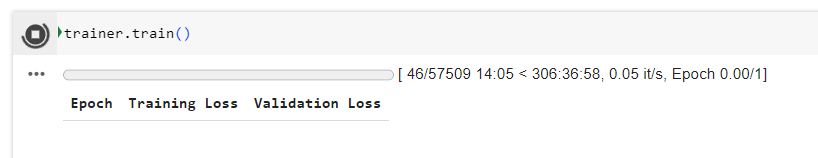

In [48]:
trainer.train()

Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

# **generating the code with our model**


---


note: it has weak accuracy because of i used opensource model and it is weak without retraining it with a data specific with this task





*   inputs['input_ids'] : the tokenized input system
*   max_length : the maximum length of the generated sequence


*   temperature : control the randomness of the output
*   top_p : top-p sampling. Instead of sampling from the entire distribution of possible next tokens





In [ ]:

def generate_code(query: str) -> str:
    schema = get_dataframe_schema(df)
    prompt = (
        f"""
        The DataFrame has the following schema: {schema}.
        Convert the following natural language query into a pandas command. Here are some examples:\n\n
        Example 1:\n
        Query: 'What is the maximum value for counter_2 for all of the cells?'\n
        Code: df['counter_2'].max()\n\n
        Example 2:\n
        Query: 'Calculate the mean of counter_1 column'\n
        Code: df['counter_1'].mean()\n\n
        Example 3:\n
        Query: 'Find the sum of counter_2'\n
        Code: df['counter_2'].sum()\n\n
        Now, convert this query into a pandas command. Provide only the code without additional explanations or extra text:\n
        Query: '{query}'\n
        Code:"""
   )

    # Tokenize the prompt
    inputs = tokenizer(prompt, return_tensors='pt', truncation=True, padding=True)

    # Generate code using the model
    outputs = model.generate(
        inputs['input_ids'],
        max_length=100,
        num_return_sequences=1,
        do_sample=True,
        temperature=0.7,
        top_p=0.95,
        early_stopping=True
    )

    # Decode the output to text
    code = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()

    # Clean up the output to remove any unwanted text
    # Remove everything before and including the first 'Code:' tag
    if "Code:" in code:
        code = code.split("Code:")[-1].strip()

    # Remove unwanted characters and extra text
    # Keep only lines that likely contain valid pandas code
    lines = code.split('\n')
    relevant_lines = [line.strip() for line in lines if 'df' in line]

    # Combine relevant lines into a single line of code
    if relevant_lines:
        # Choose the first relevant line, assuming it is the most accurate
        return relevant_lines[0]
    else:
        return "No relevant code found."



# Example usage
sample_query = "What is the max value for counter_2 for all of the cells?"
generated_code = generate_code(sample_query)
print("Generated Code (CodeT5-large):")
print(generated_code)


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:615: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


Generated Code (CodeT5-large):
df['counter_2'].max()




*   pandas.eval() : The function first attempts to evaluate the command
*   the function then tries to execute the command as standard Python code using exec() if the pandas.eval() failed



In [ ]:
def execute_pandas_command(df: pd.DataFrame, command: str):
    # Print the command for debugging purposes
    print(f"Executing command: {command}")

    try:
        # Use pd.eval if the command is a simple expression
        result = pd.eval(command, engine='python')
        return result
    except Exception as e:
        # If pd.eval fails, try executing as Python code
        local_vars = {'df': df}
        try:
            exec(command, globals(), local_vars)
            # Return the result if it's a single variable or Series
            if 'result' in local_vars:
                return local_vars['result']
            return local_vars
        except Exception as e:
            return f"Error executing command: {e}"

# testing LLM model

In [ ]:
# Example usage
sample_query = "What is the max value for counter_2 "
pandas_code = generate_code(sample_query)

print("Generated Pandas Code:")
print(pandas_code)

pandas_code = pandas_code.strip('"').strip("'")

# Execute the generated code on the DataFrame
results = execute_pandas_command(df, pandas_code)


# Print the result
print("Results:")
print(results)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:615: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


Generated Pandas Code:
'df['counter_2'].max()
Executing command: df['counter_2'].max()
Results:
6603080
